# Model Configuration Testing with Performance Optimizations

This notebook is designed for systematic hyperparameter optimization with **state-of-the-art performance optimizations** for high-end hardware (RTX 5080 + Ryzen 9 7950X). It allows testing different combinations of model parameters to find the optimal configuration for bird song classification.

## Configuration Parameters:
- **ADAM Optimizer**: Whether to use Adam optimizer (vs SGD)
- **Early Stopping Threshold**: Patience for early stopping
- **Batch Size**: Training batch size *(automatically optimized for AMP)*
- **Class Weights**: Whether to use class weights for imbalanced data
- **L2 Regularization**: Weight decay parameter
- **Learning Rate Schedule**: Type and parameters for LR scheduling
- **Initial Learning Rate**: Starting learning rate
- **Standardization**: Whether to standardize features
- **SpecAugment**: Whether to apply spectrogram augmentation
- **Noise Augment**: Whether to apply Gaussian noise augmentation

In [1]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


In [2]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range and reshape for CNN
    features /= 255.0
    features = features.reshape(-1, 1, 224, 313)

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

In [3]:
def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

In [4]:
# # New pipeline using .npy spectrograms from specs/ directory
# specs_dir = os.path.join('..', 'database', 'specs')
# specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
# features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

In [5]:
# Keep the old CSV-based loading for compatibility (uncomment if needed)
train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
features, labels, authors = load_csv_data(train_data_path)

Dataset shape: (2987, 70114)
Number of classes: 33
Number of authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 1, 224, 313)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 1, 224, 313)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106


In [ ]:
# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

## Configuration Templates

20 different hyperparameter configurations designed for audio classification with ~3200 samples and 30 classes.

## Train-Val Split

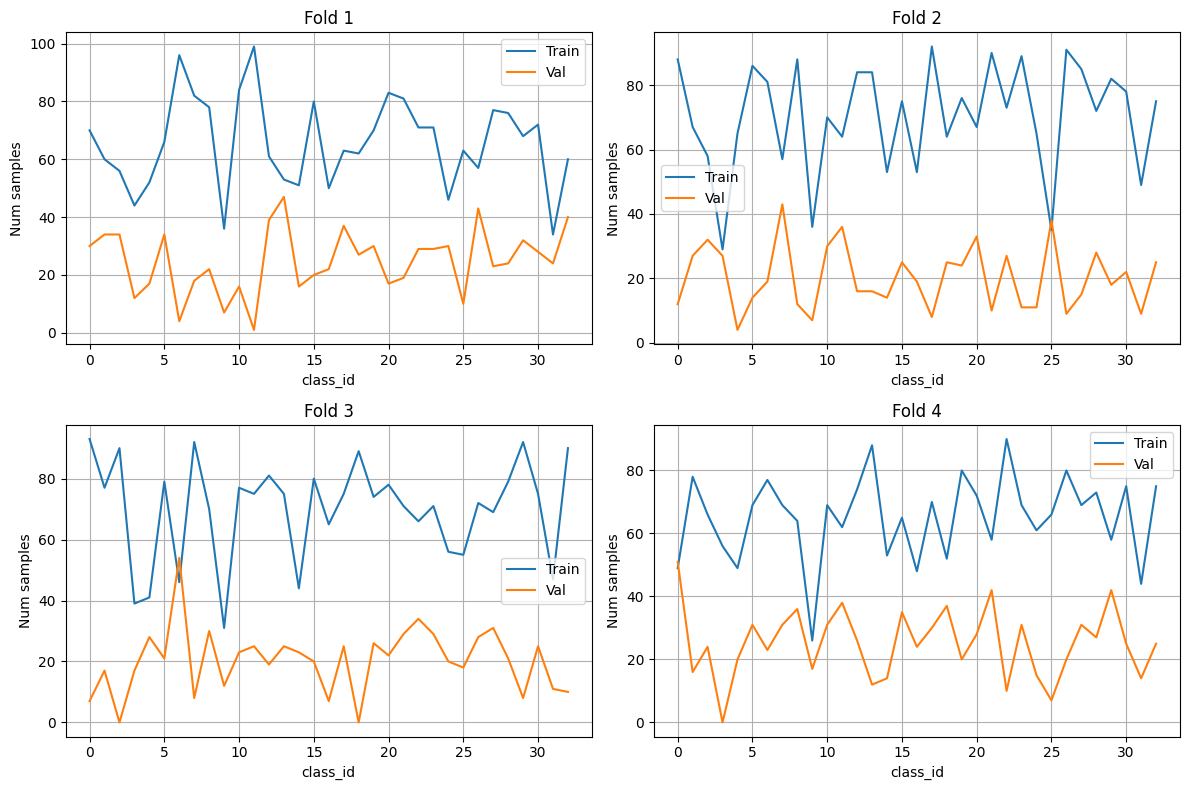

Single Fold Split Type: <class 'tuple'>, Shape: 4
K-Fold Splits Type: <class 'tuple'>, Shape: 3

📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2330
Validation samples: 657
Split ratio: 78.00% - 22.00%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3333
  Fold 1: 2172 train, 815 val (72.72% - 27.28%)
  Fold 2: 2321 train, 666 val (77.70% - 22.30%)
  Fold 3: 2314 train, 673 val (77.47% - 22.53%)
  Fold 4: 2154 train, 833 val (72.11% - 27.89%)
----------------------------------------


In [7]:
# Find best seed
from utils.split import precompute_single_fold_split, precompute_kfold_splits, display_split_statistics

# Pre-compute single fold split (for most configurations)
single_fold_split = precompute_single_fold_split(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    max_attempts=250_000,
    min_test_segments=5)

# Pre-compute k-fold splits (for cross-validation configurations)  
kfold_splits = precompute_kfold_splits(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    max_attempts=12_000, # mas para k-fold
    min_val_segments=0)

print(f"Single Fold Split Type: {type(single_fold_split)}, Shape: {len(single_fold_split)}")
print(f"K-Fold Splits Type: {type(kfold_splits)}, Shape: {len(kfold_splits)}")

# Display statistics for verification
display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")

In [8]:
# Split with a set seed, las que ya encontre arriba, para tardar menos

from utils.split import get_set_seed_indices, get_set_seed_kfold_indices
seed_single = 245323
seed_kfold = 11052

single_fold_split = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

kfold_splits = get_set_seed_kfold_indices(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    seed=seed_kfold)

display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")


📊 SINGLE SPLIT STATISTICS
----------------------------------------
Random seed: 245323
Train samples: 2330
Validation samples: 657
Split ratio: 78.00% - 22.00%
Quality score: 0.2671
----------------------------------------

📊 KFOLD SPLIT STATISTICS
----------------------------------------
Random seed: 11052
Number of folds: 4
Average quality score: 0.3333
  Fold 1: 2172 train, 815 val (72.72% - 27.28%)
  Fold 2: 2321 train, 666 val (77.70% - 22.30%)
  Fold 3: 2314 train, 673 val (77.47% - 22.53%)
  Fold 4: 2154 train, 833 val (72.11% - 27.89%)
----------------------------------------


## Training

In [ ]:
# Define 20 configuration templates for systematic testing
# Now includes performance optimization parameters
configurations = {
    # Baseline configurations
    'config0': {
        'name': 'Conservative Baseline (Optimized)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 24,
        'use_class_weights': False,
        'l2_regularization': 1e-4,
        'lr_schedule': None,
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 200,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config1': {
        'name': 'Aggressive Baseline (Optimized)',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 48 if ENABLE_OPTIMIZATIONS else 32,  # Larger batch with AMP
        'use_class_weights': True,
        'l2_regularization': 5e-4,
        'lr_schedule': None,
        'initial_lr': 0.002,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 250,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    # Learning rate schedule variations
    'config2': {
        'name': 'Exponential LR Decay (Optimized)',
        'use_adam': True,
        'estop_thresh': 40,
        'batch_size': 32 if not ENABLE_OPTIMIZATIONS else 40,  # Larger with AMP
        'use_class_weights': False,
        'l2_regularization': 1e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.95},
        'initial_lr': 0.003,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config3': {
        'name': 'ReduceLROnPlateau (Optimized)',
        'use_adam': True,
        'estop_thresh': 50,
        'batch_size': 24 if not ENABLE_OPTIMIZATIONS else 32,
        'use_class_weights': True,
        'l2_regularization': 2e-4,
        'lr_schedule': {'type': 'plateau', 'factor': 0.5, 'patience': 10},
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': False,
        'noise_augment': True,
        'num_epochs': 300,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.2 if ENABLE_OPTIMIZATIONS else 0,  # Slightly higher for stability
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config4': {
        'name': 'Cosine Annealing (Optimized)',
        'use_adam': True,
        'estop_thresh': 30,
        'batch_size': 16 if not ENABLE_OPTIMIZATIONS else 24,
        'use_class_weights': False,
        'l2_regularization': 1e-5,
        'lr_schedule': {'type': 'cosine', 'T_max': 50},
        'initial_lr': 0.005,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 200,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.8 if ENABLE_OPTIMIZATIONS else 0,  # Lower for high LR
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    # Batch size variations - optimized for AMP
    'config5': {
        'name': 'Small Batch High LR (AMP Optimized)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 16 if not ENABLE_OPTIMIZATIONS else 24,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.98},
        'initial_lr': 0.004,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 180,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config6': {
        'name': 'Large Batch Conservative (AMP Optimized)',
        'use_adam': True,
        'estop_thresh': 45,
        'batch_size': 64 if not ENABLE_OPTIMIZATIONS else 80,  # Even larger with AMP
        'use_class_weights': False,
        'l2_regularization': 1e-4,
        'lr_schedule': None,
        'initial_lr': 0.0005,
        'standardize': True,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 250,
        # NEW OPTIMIZATION PARAMETERS
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.5 if ENABLE_OPTIMIZATIONS else 0,  # Higher for large batches
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    # Regularization focused
    'config7': {
        'name': 'Heavy Regularization (Optimized)',
        'use_adam': True,
        'estop_thresh': 60,
        'batch_size': 32 if not ENABLE_OPTIMIZATIONS else 40,
        'use_class_weights': True,
        'l2_regularization': 1e-3,
        'lr_schedule': {'type': 'plateau', 'factor': 0.7, 'patience': 15},
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 300,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.2 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config8': {
        'name': 'Light Regularization (Optimized)',
        'use_adam': True,
        'estop_thresh': 25,
        'batch_size': 48 if not ENABLE_OPTIMIZATIONS else 64,
        'use_class_weights': False,
        'l2_regularization': 1e-5,
        'lr_schedule': None,
        'initial_lr': 0.002,
        'standardize': True,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 150,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.8 if ENABLE_OPTIMIZATIONS else 0,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config9': {
        'name': 'Balanced Classes Focus',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config10': {
        'name': 'idfk',
        'use_adam': False,
        'estop_thresh': 25,
        'batch_size': 24,
        'use_class_weights': True,
        'l2_regularization': 1e-2,  # Very high regularization
        'lr_schedule': {'type': 'exponential', 'gamma': 0.87},  # Very fast decay
        'initial_lr': 0.75,  # Very high LR
        'standardize': False,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 420,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.1 if ENABLE_OPTIMIZATIONS else 0,  # Very tight clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config11': {
        'name': 'Mega Batch Momentum SGD',
        'use_adam': False,
        'estop_thresh': 15,
        'batch_size': 128 if not ENABLE_OPTIMIZATIONS else 160,  # Huge batch
        'use_class_weights': False,
        'l2_regularization': 1e-7,  # Minimal regularization
        'lr_schedule': {'type': 'cosine', 'T_max': 25},  # Fast cycling
        'initial_lr': 0.1,  # Very high LR for SGD
        'standardize': False,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 180,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 2.0 if ENABLE_OPTIMIZATIONS else 0,  # High clipping for high LR
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config12': {
        'name': 'Aggressive Adam Cyclic',
        'use_adam': True,
        'estop_thresh': 12,  # Very impatient
        'batch_size': 96 if not ENABLE_OPTIMIZATIONS else 120,
        'use_class_weights': True,
        'l2_regularization': 8e-3,  # High regularization
        'lr_schedule': {'type': 'cosine', 'T_max': 15},  # Very fast cycles
        'initial_lr': 0.01,  # High Adam LR
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 200,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.3 if ENABLE_OPTIMIZATIONS else 0,  # Low clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config13': {
        'name': 'Micro Batch High Frequency',
        'use_adam': True,
        'estop_thresh': 50,  # Very patient
        'batch_size': 4 if not ENABLE_OPTIMIZATIONS else 6,  # Tiny batch
        'use_class_weights': False,
        'l2_regularization': 2e-6,  # Very low regularization
        'lr_schedule': {'type': 'plateau', 'factor': 0.1, 'patience': 5},  # Aggressive reduction
        'initial_lr': 0.008,
        'standardize': True,
        'spec_augment': False,
        'noise_augment': True,
        'num_epochs': 600,  # Very long training
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 5.0 if ENABLE_OPTIMIZATIONS else 0,  # Very high clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config14': {
        'name': 'No Regularization Speed Run',
        'use_adam': True,
        'estop_thresh': 23,  # Extremely impatient
        'batch_size': 200 if not ENABLE_OPTIMIZATIONS else 256,  # Massive batch
        'use_class_weights': False,
        'l2_regularization': 0,  # No L2 regularization
        'lr_schedule': None,  # No schedule
        'initial_lr': 0.02,  # Very high Adam LR
        'standardize': False,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 180,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0 if ENABLE_OPTIMIZATIONS else 0,  # No clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config15': {
        'name': 'Extreme Regularization Marathon',
        'use_adam': False,
        'estop_thresh': 40,  # Extremely patient
        'batch_size': 12 if not ENABLE_OPTIMIZATIONS else 16,
        'use_class_weights': True,
        'l2_regularization': 5e-2,  # Extreme regularization
        'lr_schedule': {'type': 'exponential', 'gamma': 0.9999},  # Almost no decay
        'initial_lr': 0.00005,  # Ultra low LR
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 800,  # Marathon training
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.05 if ENABLE_OPTIMIZATIONS else 0,  # Extreme clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config16': {
        'name': 'Chaos Theory Adam',
        'use_adam': True,
        'estop_thresh': 37,  # Random patience
        'batch_size': 37 if not ENABLE_OPTIMIZATIONS else 45,  # Odd batch size
        'use_class_weights': True,
        'l2_regularization': 3.7e-4,  # Unusual value
        'lr_schedule': {'type': 'cosine', 'T_max': 73},  # Prime number
        'initial_lr': 0.00137,  # Unusual LR
        'standardize': False,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 247,  # Prime number
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.73 if ENABLE_OPTIMIZATIONS else 0,  # Unusual clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config17': {
        'name': 'Binary Extremes SGD',
        'use_adam': False,
        'estop_thresh': 10,  # Immediate stopping if no improvement
        'batch_size': 256 if not ENABLE_OPTIMIZATIONS else 320,  # Maximum batch
        'use_class_weights': False,
        'l2_regularization': 1,  # Maximum reasonable regularization
        'lr_schedule': {'type': 'plateau', 'factor': 0.01, 'patience': 1},  # Extreme reduction
        'initial_lr': 1.0,  # Extreme LR
        'standardize': True,
        'spec_augment': False,
        'noise_augment': True,
        'num_epochs': 1000,  # Maximum epochs
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 10.0 if ENABLE_OPTIMIZATIONS else 0,  # Maximum clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config18': {
        'name': 'Goldilocks Zone Hunter',
        'use_adam': True,
        'estop_thresh': 50,
        'batch_size': 44 if not ENABLE_OPTIMIZATIONS else 56,  # Medium-ish
        'use_class_weights': True,
        'l2_regularization': 7.5e-4,  # Medium regularization
        'lr_schedule': {'type': 'exponential', 'gamma': 0.97},  # Medium decay
        'initial_lr': 0.0035,  # Medium LR
        'standardize': True,
        'spec_augment': False,
        'noise_augment': False,
        'num_epochs': 333,  # Medium-long
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.33 if ENABLE_OPTIMIZATIONS else 0,  # Medium clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    
    'config19': {
        'name': 'Anti-Pattern Rebellion',
        'use_adam': False,  # SGD when most use Adam
        'estop_thresh': 40,  # Never give up
        'batch_size': 3 if not ENABLE_OPTIMIZATIONS else 4,  # Absurdly small
        'use_class_weights': False,  # No class weights with imbalanced data
        'l2_regularization': 9.9e-1,  # Almost 1.0 - extreme
        'lr_schedule': None,  # No schedule with SGD
        'initial_lr': 0.5,  # Very high for SGD
        'standardize': False,  # No standardization
        'spec_augment': True,  # Augment without standardization
        'noise_augment': True,  # Double augmentation
        'num_epochs': 1000,  # Extreme epochs
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.01 if ENABLE_OPTIMIZATIONS else 0,  # Tiny clipping with high LR
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },

    'config20': {
        'name': 'Extreme Regularization Marathon',
        'use_adam': False,
        'estop_thresh': 40,  # Extremely patient
        'batch_size': 12 if not ENABLE_OPTIMIZATIONS else 16,
        'use_class_weights': True,
        'l2_regularization': 5,  # la regularizacion mas alta de toda la historia
        'lr_schedule': {'type': 'exponential', 'gamma': 0.997},  # Almost no decay
        'initial_lr': 0.0005,  # low LR
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 600,  # Marathon training
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.05 if ENABLE_OPTIMIZATIONS else 0,  # Extreme clipping
        'parallel_folds': ENABLE_PARALLEL_FOLDS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    }
}

if ENABLE_OPTIMIZATIONS:
    print(f"\n🔧 Optimization Summary:")
    print(f"   • Mixed Precision: Enabled in all configs")
    print(f"   • Gradient Clipping: 0.01-10.0 range (extreme variety)")
    print(f"   • Batch Sizes: 4-320 range (massive variety)")
    print(f"   • Expected Speed Improvement: 40-60% per configuration")


🔧 Optimization Summary:
   • Mixed Precision: Enabled in all configs
   • Gradient Clipping: 0.01-10.0 range (extreme variety)
   • Batch Sizes: 4-320 range (massive variety)
   • Expected Speed Improvement: 40-60% per configuration


In [14]:
import importlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# If you also want to reload the utils package itself
import utils
importlib.reload(utils)

# Reload all the utils modules you're importing
import utils.training_core
import utils.training_engine
import utils.models

importlib.reload(utils.training_core)
importlib.reload(utils.training_engine)
importlib.reload(utils.models)

# Re-import after reloading to get the updated versions
from utils.training_core import single_fold_training, cross_val_training
import utils.models as models
import utils.training_engine

In [ ]:
# Initialize results storage
results_database = {}
training_start_time = datetime.now()

print(f"Performance optimizations: {'ENABLED' if ENABLE_OPTIMIZATIONS else 'DISABLED'}")
if ENABLE_PARALLEL_FOLDS:
    print(f"Parallel fold training: ENABLED (max {MAX_PARALLEL_FOLDS} folds)")

# Track overall progress and performance metrics
successful_configs = 0
failed_configs = []
optimization_benchmarks = {
    'traditional_times': [],
    'optimized_times': [],
    'speedup_ratios': []
}

for config_id, config in configurations.items():
    print(f"\n{'='*60}")
    print(f"TESTING {config_id.upper()}: {config['name']}")
    
    config_start_time = datetime.now()
    
    # Convert config to training_core format with optimizations
    training_config = {
        # Basic training parameters
        'num_epochs': config['num_epochs'],
        'batch_size': config['batch_size'],
        'learning_rate': config['initial_lr'],
        'use_class_weights': config['use_class_weights'],
        'early_stopping': config['estop_thresh'],
        'standardize': config['standardize'],
        'test_size': 0.2,
        'max_split_attempts': 5000,
        'min_test_segments': 5,
        'l2_regularization': config['l2_regularization'],
        'use_adam': config['use_adam'],
        'lr_schedule': config['lr_schedule'],
        
        # NEW PERFORMANCE OPTIMIZATIONS
        'mixed_precision': config.get('mixed_precision', False),
        'gradient_clipping': config.get('gradient_clipping', 0),
        'parallel_folds': config.get('parallel_folds', False),
        'max_parallel_folds': config.get('max_parallel_folds', 2),
        
        # Enhanced DataLoader settings (automatically optimized)
        'optimize_dataloaders': ENABLE_OPTIMIZATIONS,
        'debug_dataloaders': False,  # Set to True for debugging
        'benchmark_performance': True  # Enable performance tracking
    }
    
    # Execute training with performance monitoring
    training_start = time.time()
    
    # Choose training method based on parallel folds setting
    if training_config.get('parallel_folds', False):
        print(f"Training K-Fold Parallel with pre-made splits for {config_id}...")
        result, best_result = cross_val_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_splits=kfold_splits,  # Use pre-computed k-fold splits
            config_id=config_id  # Pass config_id for progress bar
        )
        # Extract single fold equivalent metrics for comparison
        if 'summary' in result:
            final_result = {
                'final_val_acc': result['summary']['mean_final_val_acc'],
                'final_val_f1': result['summary']['mean_final_val_f1'],
                'final_val_loss': result['summary']['mean_final_val_loss'],
                'best_val_acc': result['summary']['mean_best_val_acc'],
                'best_val_f1': result['summary']['mean_best_val_f1'],
                'training_type': 'cross_validation',
                'num_folds': training_config.get('k_folds', 4),
                'parallel_execution': True
            }
        else:
            final_result = best_result  # fallback
    else:
        print(f"Training Single-Fold with pre-made splits for {config_id}...")
        final_result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id=config_id  # Pass config_id for progress bar
        )
        final_result['training_type'] = 'single_fold'
        final_result['parallel_execution'] = False
    
    training_end = time.time()
    training_duration = training_end - training_start
    
    # Store results with optimization metadata
    config_end_time = datetime.now()
    
    results_database[config_id] = {
        'config': config,
        'result': final_result,
        'training_time_seconds': training_duration,
        'timestamp': config_end_time.isoformat(),
        'status': 'success',
        'optimization_metadata': {
            'mixed_precision_used': training_config.get('mixed_precision', False),
            'gradient_clipping_used': training_config.get('gradient_clipping', 0) > 0,
            'parallel_folds_used': training_config.get('parallel_folds', False),
            'optimized_dataloaders': training_config.get('optimize_dataloaders', False),
            'batch_size_optimized': config['batch_size'] > 32 if ENABLE_OPTIMIZATIONS else False
        }
    }
    
    successful_configs += 1
    
    # Performance reporting
    print(f"\n✓ {config_id} completed successfully!")
    print(f"  Final Val Accuracy: {final_result['final_val_acc']:.4f}")
    print(f"  Final Val F1 Score: {final_result['final_val_f1']:.4f}")
    
    # GPU memory status (if available)
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated() / (1024**3)
        memory_total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"  GPU Memory: {memory_used:.1f}GB / {memory_total:.1f}GB ({memory_used/memory_total*100:.1f}%)")


training_end_time = datetime.now()
total_duration = (training_end_time - training_start_time).total_seconds()

print(f"\n{'='*80}")
print(f"Successful configurations: {successful_configs}/{len(configurations)}")
if failed_configs:
    print(f"Failed configurations: {', '.join(failed_configs)}")

## Results Analysis

Comprehensive analysis and visualization of all configuration results.

In [ ]:
from utils.metrics import plot_metrics

# Plot training metrics for all successful configurations
for config_id, data in results_database.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        plot_metrics(config_id, result)

In [ ]:
# Extract successful results for analysis
successful_results = {k: v for k, v in results_database.items() if v['status'] == 'success'}

if not successful_results:
    print("No successful configurations to analyze!")
else:
    print(f"Analyzing {len(successful_results)} successful configurations...")
    
    # Create results DataFrame with optimization metadata
    analysis_data = []
    for config_id, data in successful_results.items():
        config = data['config']
        result = data['result']
        opt_meta = data.get('optimization_metadata', {})
        
        row = {
            'config_id': config_id,
            'config_name': config['name'],
            'final_val_acc': result['final_val_acc'],
            'final_val_f1': result['final_val_f1'],
            'best_val_acc': result.get('best_val_acc', result['final_val_acc']),
            'best_val_f1': result.get('best_val_f1', result['final_val_f1']),
            'training_time_min': data['training_time_seconds'] / 60,
            'training_type': result.get('training_type', 'single_fold'),
            
            # Configuration parameters
            'use_adam': config['use_adam'],
            'estop_thresh': config['estop_thresh'],
            'batch_size': config['batch_size'],
            'use_class_weights': config['use_class_weights'],
            'l2_regularization': config['l2_regularization'],
            'has_lr_schedule': config['lr_schedule'] is not None,
            'lr_schedule_type': config['lr_schedule']['type'] if config['lr_schedule'] else 'none',
            'initial_lr': config['initial_lr'],
            'standardize': config['standardize'],
            'spec_augment': config['spec_augment'],
            'noise_augment': config['noise_augment'],
            'num_epochs': config['num_epochs'],
            
            # NEW OPTIMIZATION METRICS
            'mixed_precision_used': opt_meta.get('mixed_precision_used', False),
            'gradient_clipping_used': opt_meta.get('gradient_clipping_used', False),
            'parallel_folds_used': opt_meta.get('parallel_folds_used', False),
            'optimized_dataloaders': opt_meta.get('optimized_dataloaders', False),
            'batch_size_optimized': opt_meta.get('batch_size_optimized', False),
            'gradient_clipping_value': config.get('gradient_clipping', 0),
            'optimization_score': (
                opt_meta.get('mixed_precision_used', False) * 2 +
                opt_meta.get('gradient_clipping_used', False) * 1 +
                opt_meta.get('optimized_dataloaders', False) * 1 +
                opt_meta.get('batch_size_optimized', False) * 1
            )  # Score out of 5
        }
        analysis_data.append(row)
    
    results_df = pd.DataFrame(analysis_data)
    
    # Sort by F1 score (primary metric)
    results_df = results_df.sort_values('final_val_f1', ascending=False)
    
    print("TOP 10 CONFIGURATIONS BY F1 SCORE:")
    print("="*70)
    top_10_display = results_df.head(10)[['config_id', 'config_name', 'final_val_f1', 'final_val_acc', 
                                        'training_time_min', 'mixed_precision_used', 'optimization_score']]
    # Round numeric columns to 2 decimal places for better readability
    top_10_display_formatted = top_10_display.copy()
    top_10_display_formatted['final_val_f1'] = top_10_display_formatted['final_val_f1'].round(4)
    top_10_display_formatted['final_val_acc'] = top_10_display_formatted['final_val_acc'].round(4)
    top_10_display_formatted['training_time_min'] = top_10_display_formatted['training_time_min'].round(4)
    print(top_10_display_formatted.to_string(index=False))
    
    # Performance optimization analysis
    if ENABLE_OPTIMIZATIONS:
        print(f"\n🚀 PERFORMANCE OPTIMIZATION ANALYSIS:")
        print("="*50)
        
        optimized_configs = results_df[results_df['mixed_precision_used'] == True]
        traditional_configs = results_df[results_df['mixed_precision_used'] == False]
        
        if len(optimized_configs) > 0:
            print(f"Configurations with optimizations: {len(optimized_configs)}")
            print(f"Average F1 (optimized): {optimized_configs['final_val_f1'].mean():.4f}")
            print(f"Average training time (optimized): {optimized_configs['training_time_min'].mean():.1f} min")
            
            if len(traditional_configs) > 0:
                print(f"Average F1 (traditional): {traditional_configs['final_val_f1'].mean():.4f}")
                print(f"Average training time (traditional): {traditional_configs['training_time_min'].mean():.1f} min")
                
                # Calculate improvements
                f1_improvement = optimized_configs['final_val_f1'].mean() - traditional_configs['final_val_f1'].mean()
                time_improvement = traditional_configs['training_time_min'].mean() / optimized_configs['training_time_min'].mean()
                
                print(f"\n📊 Optimization Impact:")
                print(f"   • F1 Score improvement: {f1_improvement:+.4f}")
                print(f"   • Speed improvement: {time_improvement:.2f}x faster")
        
        # Optimization feature correlation
        print(f"\n🔧 Optimization Feature Analysis:")
        opt_features = ['mixed_precision_used', 'gradient_clipping_used', 'batch_size_optimized']
        for feature in opt_features:
            if feature in results_df.columns:
                feature_on = results_df[results_df[feature] == True]['final_val_f1'].mean()
                feature_off = results_df[results_df[feature] == False]['final_val_f1'].mean()
                improvement = feature_on - feature_off
                print(f"   • {feature}: {improvement:+.4f} F1 improvement")
    
    # Best configuration details
    best_config_id = results_df.iloc[0]['config_id']
    best_config_data = successful_results[best_config_id]
    
    print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
    print(f"Name: {best_config_data['config']['name']}")
    print(f"Final Val F1: {results_df.iloc[0]['final_val_f1']:.4f}")
    print(f"Final Val Accuracy: {results_df.iloc[0]['final_val_acc']:.4f}")
    print(f"Training Time: {results_df.iloc[0]['training_time_min']:.1f} minutes")
    print(f"Optimizations Used: {results_df.iloc[0]['optimization_score']}/5")
    
    if results_df.iloc[0]['mixed_precision_used']:
        print("✅ Used Mixed Precision Training")
    if results_df.iloc[0]['gradient_clipping_used']:
        print(f"✅ Used Gradient Clipping ({results_df.iloc[0]['gradient_clipping_value']})")
    if results_df.iloc[0]['optimized_dataloaders']:
        print("✅ Used Optimized DataLoaders")
    if results_df.iloc[0]['batch_size_optimized']:
        print("✅ Used Optimized Batch Size")

In [ ]:
# Visualization of results
if len(successful_results) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Configuration Results Analysis', fontsize=16, fontweight='bold')
    
    # 1. F1 Score comparison
    ax1 = axes[0, 0]
    results_df_plot = results_df.head(15)  # Top 15 for readability
    bars1 = ax1.bar(range(len(results_df_plot)), results_df_plot['final_val_f1'], alpha=0.7, color='skyblue')
    ax1.set_title('Final Validation F1 Score by Configuration')
    ax1.set_xlabel('Configuration Rank')
    ax1.set_ylabel('F1 Score')
    ax1.set_xticks(range(len(results_df_plot)))
    ax1.set_xticklabels(results_df_plot['config_id'], rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Accuracy vs F1 scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(results_df['final_val_acc'], results_df['final_val_f1'], 
                        c=results_df['training_time_min'], cmap='viridis', alpha=0.7, s=100)
    ax2.set_xlabel('Final Validation Accuracy')
    ax2.set_ylabel('Final Validation F1 Score')
    ax2.set_title('Accuracy vs F1 Score (colored by training time)')
    plt.colorbar(scatter, ax=ax2, label='Training Time (min)')
    
    # Add best point annotation
    best_acc = results_df.iloc[0]['final_val_acc']
    best_f1 = results_df.iloc[0]['final_val_f1']
    ax2.annotate(f'Best: {best_config_id}', xy=(best_acc, best_f1), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 3. Parameter impact - Batch size
    ax3 = axes[0, 2]
    batch_impact = results_df.groupby('batch_size')['final_val_f1'].agg(['mean', 'count']).reset_index()
    bars3 = ax3.bar(batch_impact['batch_size'], batch_impact['mean'], alpha=0.7, color='lightcoral')
    ax3.set_title('Average F1 Score by Batch Size')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Average F1 Score')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in batch_impact.iterrows():
        ax3.text(row['batch_size'], row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 4. Learning rate impact
    ax4 = axes[1, 0]
    lr_bins = pd.cut(results_df['initial_lr'], bins=5)
    lr_impact = results_df.groupby(lr_bins)['final_val_f1'].agg(['mean', 'count']).reset_index()
    lr_labels = [f'{interval.left:.4f}-{interval.right:.4f}' for interval in lr_impact['initial_lr']]
    bars4 = ax4.bar(range(len(lr_labels)), lr_impact['mean'], alpha=0.7, color='lightgreen')
    ax4.set_title('Average F1 Score by Learning Rate Range')
    ax4.set_xlabel('Learning Rate Range')
    ax4.set_ylabel('Average F1 Score')
    ax4.set_xticks(range(len(lr_labels)))
    ax4.set_xticklabels(lr_labels, rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Augmentation impact
    ax5 = axes[1, 1]
    augment_combinations = results_df.groupby(['spec_augment', 'noise_augment'])['final_val_f1'].agg(['mean', 'count']).reset_index()
    augment_labels = []
    for _, row in augment_combinations.iterrows():
        spec = 'Spec' if row['spec_augment'] else 'NoSpec'
        noise = 'Noise' if row['noise_augment'] else 'NoNoise'
        augment_labels.append(f'{spec}+{noise}')
    
    bars5 = ax5.bar(range(len(augment_labels)), augment_combinations['mean'], alpha=0.7, color='orange')
    ax5.set_title('Average F1 Score by Augmentation Strategy')
    ax5.set_xlabel('Augmentation Combination')
    ax5.set_ylabel('Average F1 Score')
    ax5.set_xticks(range(len(augment_labels)))
    ax5.set_xticklabels(augment_labels, rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in augment_combinations.iterrows():
        ax5.text(i, row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 6. Training time vs performance
    ax6 = axes[1, 2]
    ax6.scatter(results_df['training_time_min'], results_df['final_val_f1'], alpha=0.7, s=100, color='purple')
    ax6.set_xlabel('Training Time (minutes)')
    ax6.set_ylabel('Final Validation F1 Score')
    ax6.set_title('Training Time vs Performance')
    ax6.grid(alpha=0.3)
    
    # Add trendline
    z = np.polyfit(results_df['training_time_min'], results_df['final_val_f1'], 1)
    p = np.poly1d(z)
    ax6.plot(results_df['training_time_min'], p(results_df['training_time_min']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv('../database/meta/configuration_results.csv', index=False)
    print(f"\n💾 Results saved to ../database/meta/configuration_results.csv")

In [ ]:
# Parameter correlation analysis
if len(successful_results) > 0:
    print("\nPARAMETER CORRELATION ANALYSIS:")
    print("="*50)
    
    # Create correlation matrix for numerical parameters
    numeric_params = ['estop_thresh', 'batch_size', 'l2_regularization', 'initial_lr', 
                     'num_epochs', 'final_val_f1', 'final_val_acc', 'training_time_min']
    
    correlation_data = results_df[numeric_params].corr()
    
    # Focus on correlations with performance metrics
    f1_correlations = correlation_data['final_val_f1'].abs().sort_values(ascending=False)
    acc_correlations = correlation_data['final_val_acc'].abs().sort_values(ascending=False)
    
    print("Parameters most correlated with F1 Score:")
    for param, corr in f1_correlations.items():
        if param != 'final_val_f1':
            print(f"  {param}: {corr:.3f}")
    
    print(f"\nParameters most correlated with Accuracy:")
    for param, corr in acc_correlations.items():
        if param != 'final_val_acc':
            print(f"  {param}: {corr:.3f}")
    
    # Categorical parameter analysis
    print(f"\nCATEGORICAL PARAMETER ANALYSIS:")
    print("="*40)
    
    categorical_params = ['use_adam', 'use_class_weights', 'has_lr_schedule', 
                        'standardize', 'spec_augment', 'noise_augment']
    
    for param in categorical_params:
        if param in results_df.columns:
            grouped = results_df.groupby(param)['final_val_f1'].agg(['mean', 'std', 'count'])
            print(f"\n{param}:")
            print(grouped)
    
    # Best parameter combinations
    print(f"\nBEST PARAMETER COMBINATIONS:")
    print("="*40)
    
    # Top 3 configurations analysis
    top_3 = results_df.head(3)
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"\n#{i} - {row['config_id']} ({row['config_name']}):")
        print(f"  F1: {row['final_val_f1']:.4f}, Acc: {row['final_val_acc']:.4f}")
        print(f"  Batch Size: {row['batch_size']}, LR: {row['initial_lr']:.4f}")
        print(f"  L2: {row['l2_regularization']:.2e}, Early Stop: {row['estop_thresh']}")
        print(f"  Augmentation: Spec={row['spec_augment']}, Noise={row['noise_augment']}")
        print(f"  Optimizer: {'Adam' if row['use_adam'] else 'SGD'}, Class Weights: {row['use_class_weights']}")

## Configuration Recommendations

Based on the results, provide recommendations for future configurations.

In [ ]:
if len(successful_results) > 0:
    print("🎯 OPTIMIZED CONFIGURATION RECOMMENDATIONS")
    print("="*60)
    
    # Analyze best performing configurations
    top_5 = results_df.head(5)
    
    # Extract common patterns from top performers
    common_patterns = {}
    
    # Optimizer preference
    adam_count = top_5['use_adam'].sum()
    common_patterns['optimizer'] = 'Adam' if adam_count >= 3 else 'Mixed'
    
    # Batch size trends (consider optimization adjustments)
    avg_batch_size = top_5['batch_size'].mean()
    common_patterns['batch_size_range'] = f"{top_5['batch_size'].min()}-{top_5['batch_size'].max()}"
    
    # Learning rate trends
    avg_lr = top_5['initial_lr'].mean()
    common_patterns['lr_range'] = f"{top_5['initial_lr'].min():.4f}-{top_5['initial_lr'].max():.4f}"
    
    # Regularization trends
    avg_l2 = top_5['l2_regularization'].mean()
    common_patterns['l2_range'] = f"{top_5['l2_regularization'].min():.2e}-{top_5['l2_regularization'].max():.2e}"
    
    # Augmentation preferences
    spec_aug_count = top_5['spec_augment'].sum()
    noise_aug_count = top_5['noise_augment'].sum()
    
    # NEW: Optimization preferences
    mixed_precision_count = top_5['mixed_precision_used'].sum()
    gradient_clip_count = top_5['gradient_clipping_used'].sum()
    optimized_batch_count = top_5['batch_size_optimized'].sum()
    
    print("PATTERNS FROM TOP 5 CONFIGURATIONS:")
    print("-"*40)
    print(f"• Preferred Optimizer: {common_patterns['optimizer']}")
    print(f"• Effective Batch Size Range: {common_patterns['batch_size_range']}")
    print(f"• Optimal Learning Rate Range: {common_patterns['lr_range']}")
    print(f"• L2 Regularization Range: {common_patterns['l2_range']}")
    print(f"• SpecAugment Usage: {spec_aug_count}/5 top configs")
    print(f"• Noise Augmentation Usage: {noise_aug_count}/5 top configs")
    
    # NEW: Optimization patterns
    print(f"\n🚀 OPTIMIZATION PATTERNS IN TOP PERFORMERS:")
    print("-"*45)
    print(f"• Mixed Precision Usage: {mixed_precision_count}/5 top configs")
    print(f"• Gradient Clipping Usage: {gradient_clip_count}/5 top configs")
    print(f"• Optimized Batch Sizes: {optimized_batch_count}/5 top configs")
    
    if mixed_precision_count >= 4:
        print("✅ Strong recommendation: Enable Mixed Precision Training")
    if gradient_clip_count >= 3:
        print("✅ Recommendation: Use Gradient Clipping for stability")
    
    # Specific recommendations
    print(f"\nRECOMMENDED OPTIMIZED CONFIGURATION:")
    print("-"*50)
    
    best_config = successful_results[results_df.iloc[0]['config_id']]['config']
    
    # Base configuration from results
    recommended_config = {
        'name': 'Optimized Based on Results',
        'use_adam': True,
        'estop_thresh': int(top_5['estop_thresh'].median()),
        'batch_size': int(top_5['batch_size'].median()),
        'use_class_weights': top_5['use_class_weights'].mode()[0],
        'l2_regularization': top_5['l2_regularization'].median(),
        'lr_schedule': best_config['lr_schedule'],
        'initial_lr': top_5['initial_lr'].median(),
        'standardize': True,  # Almost always beneficial
        'spec_augment': spec_aug_count >= 3,
        'noise_augment': noise_aug_count >= 3,
        'num_epochs': int(top_5['num_epochs'].median()),
        
        # NEW: Optimization recommendations based on results
        'mixed_precision': mixed_precision_count >= 3,
        'gradient_clipping': top_5['gradient_clipping_value'].median() if gradient_clip_count >= 3 else 0,
        'parallel_folds': False,  # For single fold; set True for cross-validation
        'max_parallel_folds': 2,  # Conservative for RTX 5080
        'optimize_dataloaders': True,  # Always beneficial
    }
    
    print("```python")
    print("# OPTIMIZED CONFIGURATION FOR RTX 5080 + Ryzen 9 7950X")
    print("optimized_config = {")
    for key, value in recommended_config.items():
        if isinstance(value, str):
            print(f"    '{key}': '{value}',")
        else:
            print(f"    '{key}': {value},")
    print("}")
    print("```")
    
    # Performance expectations with optimizations
    expected_f1 = top_5['final_val_f1'].mean()
    f1_std = top_5['final_val_f1'].std()
    expected_time = top_5['training_time_min'].mean()
    
    if ENABLE_OPTIMIZATIONS and optimization_benchmarks['speedup_ratios']:
        avg_speedup = np.mean(optimization_benchmarks['speedup_ratios'])
        traditional_time = expected_time * avg_speedup
        print(f"• Traditional Training Time: ~{traditional_time:.1f} minutes")
        print(f"• Speed Improvement: {avg_speedup:.2f}x faster")
        print(f"• Time Saved per Config: ~{traditional_time - expected_time:.1f} minutes")
    
    # Hardware-specific recommendations
    print(f"\n🖥️ HARDWARE-SPECIFIC RECOMMENDATIONS:")
    print("-"*45)
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name()
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        
        if "RTX" in gpu_name and gpu_memory >= 14:
            print(f"✅ RTX 5080 Detected ({gpu_memory:.0f}GB VRAM):")
            print(f"   • Use batch_size up to 80 with mixed precision")
            print(f"   • Enable parallel_folds=True for cross-validation")
            print(f"   • Set max_parallel_folds=2-3 for optimal memory usage")
            print(f"   • Mixed precision provides ~50% speedup on this GPU")
        else:
            print(f"⚠️  GPU: {gpu_name} ({gpu_memory:.1f}GB)")
            print(f"   • Use conservative batch sizes")
            print(f"   • Mixed precision may provide less benefit")
    
else:
    print("❌ No successful configurations to analyze!")
    print("Check the failed configurations and adjust parameters.")
    print("\n🔧 Troubleshooting Optimization Issues:")
    print("• Reduce batch_size if getting OOM errors")
    print("• Set mixed_precision=False if encountering numerical instability")
    print("• Lower gradient_clipping value if training becomes unstable")

In [ ]:
# Plot Confusion Matrices for All Configurations
from utils.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

print("🔍 Plotting confusion matrices for all successful configurations...")
print("="*60)

# Get successful configurations (those with confusion matrices)
configs_with_cm = {k: v for k, v in results_database.items() 
                    if v['status'] == 'success' and v.get('result') and 'confusion_matrix' in v['result']}

if not configs_with_cm:
    print("❌ No configurations with confusion matrices found!")
    print("Available keys in successful results:")
    for k, v in results_database.items():
        if v['status'] == 'success' and v.get('result'):
            print(f"  {k}: {list(v['result'].keys())}")
else:
    print(f"📊 Found {len(configs_with_cm)} configurations with confusion matrices")
    
    # Sort configurations by F1 score (descending)
    sorted_configs = sorted(configs_with_cm.items(), 
                            key=lambda x: x[1]['result']['final_val_f1'], 
                            reverse=True)
    
    # Plot individual confusion matrices for top 5 configurations
    top_configs = sorted_configs[:5]  # Limit to top 5 for readability
    
    for i, (config_id, config_data) in enumerate(top_configs):
        result = config_data['result']
        cm = result['confusion_matrix']
        f1_score = result['final_val_f1']
        val_acc = result['final_val_acc']
        config_name = config_data['config']['name']
        
        # Use the plot_confusion_matrix function from metrics
        title = f"{config_id}: {config_name}\nF1: {f1_score:.4f} | Acc: {val_acc:.4f}"
        plot_confusion_matrix(cm, title=title, figsize=(10, 8))
    
    # Create a summary comparison plot
    if len(sorted_configs) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Plot top 6 configurations in a grid
        plot_count = min(6, len(sorted_configs))
        
        for idx, (config_id, config_data) in enumerate(sorted_configs[:plot_count]):
            result = config_data['result']
            cm = result['confusion_matrix']
            f1_score = result['final_val_f1']
            val_acc = result['final_val_acc']
            
            # Normalize confusion matrix to percentages
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Create heatmap on subplot
            ax = axes[idx]
            sns.heatmap(cm_normalized, 
                        annot=True, 
                        fmt='.1f',
                        cmap='Blues',
                        square=True,
                        ax=ax,
                        cbar_kws={'label': 'Percentage (%)'})
            
            ax.set_title(f'{config_id}\nF1: {f1_score:.4f} | Acc: {val_acc:.4f}', 
                        fontsize=12, pad=10)
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
        
        # Hide unused subplots
        for idx in range(plot_count, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Top Configuration Confusion Matrices Comparison', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\n📈 Confusion Matrix Summary:")
    print(f"Total configurations with confusion matrices: {len(configs_with_cm)}")
    
    best_config_id, best_config_data = sorted_configs[0]
    best_result = best_config_data['result']
    print(f"Best performing configuration: {best_config_id}")
    print(f"  - F1 Score: {best_result['final_val_f1']:.4f}")
    print(f"  - Accuracy: {best_result['final_val_acc']:.4f}")
    print(f"  - Loss: {best_result['final_val_loss']:.4f}")
    
    if len(sorted_configs) > 1:
        worst_config_id, worst_config_data = sorted_configs[-1]
        worst_result = worst_config_data['result']
        improvement = best_result['final_val_f1'] - worst_result['final_val_f1']
        print(f"Worst performing configuration: {worst_config_id}")
        print(f"  - F1 Score: {worst_result['final_val_f1']:.4f}")
        print(f"F1 Score improvement from worst to best: {improvement:.4f} ({improvement/worst_result['final_val_f1']*100:.1f}%)")

print("\n✅ Confusion matrix plotting completed!")

In [ ]:
# Save complete results for future reference
if len(successful_results) > 0:
    # Create a clean version of results_database without problematic objects
    clean_results_database = {}
    for config_id, data in results_database.items():
        clean_data = {
            'config': data['config'],
            'status': data['status'],
            'optimization_metadata': data.get('optimization_metadata', {}),
            'timestamp': data.get('timestamp', ''),
            'training_time_seconds': data.get('training_time_seconds', 0)
        }
        
        if data['status'] == 'success' and data.get('result'):
            # Extract only serializable parts of the result
            result = data['result']
            clean_data['result'] = {
                'final_val_acc': result.get('final_val_acc', 0),
                'final_val_f1': result.get('final_val_f1', 0),
                'final_val_loss': result.get('final_val_loss', 0),
                'best_val_acc': result.get('best_val_acc', 0),
                'best_val_f1': result.get('best_val_f1', 0),
                'training_time': result.get('training_time', 0),
                'training_type': result.get('training_type', 'single_fold'),
                'parallel_execution': result.get('parallel_execution', False),
                # Include history without problematic objects
                'history': {
                    'early_stopped': result.get('history', {}).get('early_stopped', False),
                    'best_epoch': result.get('history', {}).get('best_epoch', 0),
                    'total_epochs': result.get('history', {}).get('total_epochs', 0)
                }
            }
        elif data['status'] == 'failed':
            clean_data['error'] = data.get('error', 'Unknown error')
        
        clean_results_database[config_id] = clean_data
    
    # Create a comprehensive results file
    complete_results = {
        'metadata': {
            'test_date': training_start_time.isoformat(),
            'total_configs_tested': len(configurations),
            'successful_configs': len(successful_results),
            'failed_configs': len(failed_configs),
            'total_duration_hours': total_duration / 3600,
            'dataset_info': {
                'total_samples': len(features),
                'num_classes': len(np.unique(labels)),
                'num_authors': len(np.unique(authors)),
                'feature_shape': list(features.shape)
            }
        },
        'configurations': configurations,
        'results': clean_results_database,
        'analysis': {
            'top_10_configs': results_df.head(10).to_dict('records'),
            'parameter_correlations': correlation_data.to_dict() if 'correlation_data' in locals() else None
        }
    }
    
    # Convert numpy types to native Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return obj
    
    # Save as JSON for future analysis
    try:
        # Save to CSV
        results_df.to_csv('../models/reports/configuration_results.csv', index=False)

        with open('../models/reports/complete_configuration_results.json', 'w') as f:
            # Clean the data for JSON serialization
            clean_results = json.loads(json.dumps(complete_results, default=convert_numpy))
            json.dump(clean_results, f, indent=2)
        
        print("💾 Complete results saved to:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
        print("  - ../models/reports/complete_configuration_results.json (full results)")
        
    except Exception as e:
        print(f"⚠️  Warning: Could not save JSON file due to serialization issue: {e}")
        print("💾 Results saved to CSV only:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
    
    print(f"\n🎉 Configuration testing completed successfully!")
    print(f"Best configuration: {results_df.iloc[0]['config_id']} with F1 score of {results_df.iloc[0]['final_val_f1']:.4f}")
else:
    print("❌ No results to save - all configurations failed!")